##**Flower Classification with Transfer Learning and Multiclass Classification** 🌺🌷🌼
## Supervised by Mustafa Youldash, Ph.D.
## Prepared by
### Student Names : Mayyan Alharbi , Watin Aljohani
### Students ID: 2210002679  ,       2210003341
### Section Number: 1



# **Introduction**

Deep learning has emerged as a transformative technology, driving innovation across domains such as computer vision, natural language processing, and autonomous systems. One of the most impactful applications of deep learning is image classification, where convolutional neural networks (CNNs) have become the foundation for achieving state-of-the-art results in various tasks [1]. CNNs are particularly effective in extracting hierarchical features from images, enabling accurate categorization of objects, scenes, and more.

This research focuses on utilizing deep learning techniques for the classification of flowers, a challenging task due to the diversity and subtle differences between classes. The tf_flowers dataset, a curated collection of flower images spanning multiple categories, is employed to train and evaluate models [2]. This project aims to explore the effectiveness of two deep learning approaches: a baseline CNN model and a transfer learning-based model using the VGG16 pre-trained network [3]. By comparing these methods, we aim to demonstrate how transfer learning can leverage pre-existing knowledge to enhance classification performance and reduce training time.

This study not only showcases the practical applications of deep learning but also emphasizes the importance of data preprocessing, augmentation, and model evaluation in developing robust classification systems.



# **Project Goals and Objectives**
This section outlines the goals and objectives that guide the development of this project, focusing on building a robust flower classification system and evaluating different modeling approaches. The primary objectives are:

>To develop a flower classification system using deep learning techniques, capable of accurately categorizing images into predefined classes.

>To evaluate the performance of a baseline CNN model and compare it with a transfer learning approach using VGG16.

>To assess the potential of transfer learning in reducing training time while improving classification accuracy.

# **Data Acquisition and Preprocessing**
The tf_flowers dataset, available through TensorFlow Datasets, was used in this study [4]. This dataset contains labeled images categorized into five flower classes: daisy, dandelion, roses, sunflowers, and tulips. The dataset was split into three subsets: 80% for training, 10% for validation, and 10% for testing, ensuring proper evaluation and model generalization.

To prepare the dataset for training, several preprocessing steps were applied. First, all images were resized to a uniform dimension of 150x150 pixels to standardize the input size. The pixel values were then normalized to the range [0, 1] to enhance computational efficiency and facilitate faster convergence during training. For the training dataset, data augmentation techniques were employed to improve model robustness by introducing variability. These techniques included random horizontal flipping, rotation (up to 10%), zooming (up to 10%), and translation (up to 10% in both horizontal and vertical directions).

The preprocessing pipeline was implemented using TensorFlow’s Keras API, which automated these operations. While augmentation was applied exclusively to the training dataset, the validation and test datasets underwent resizing and normalization only. The datasets were then batched and optimized with prefetching for efficient GPU processing. A visualization of augmented images was performed to ensure the preprocessing steps were correctly applied.

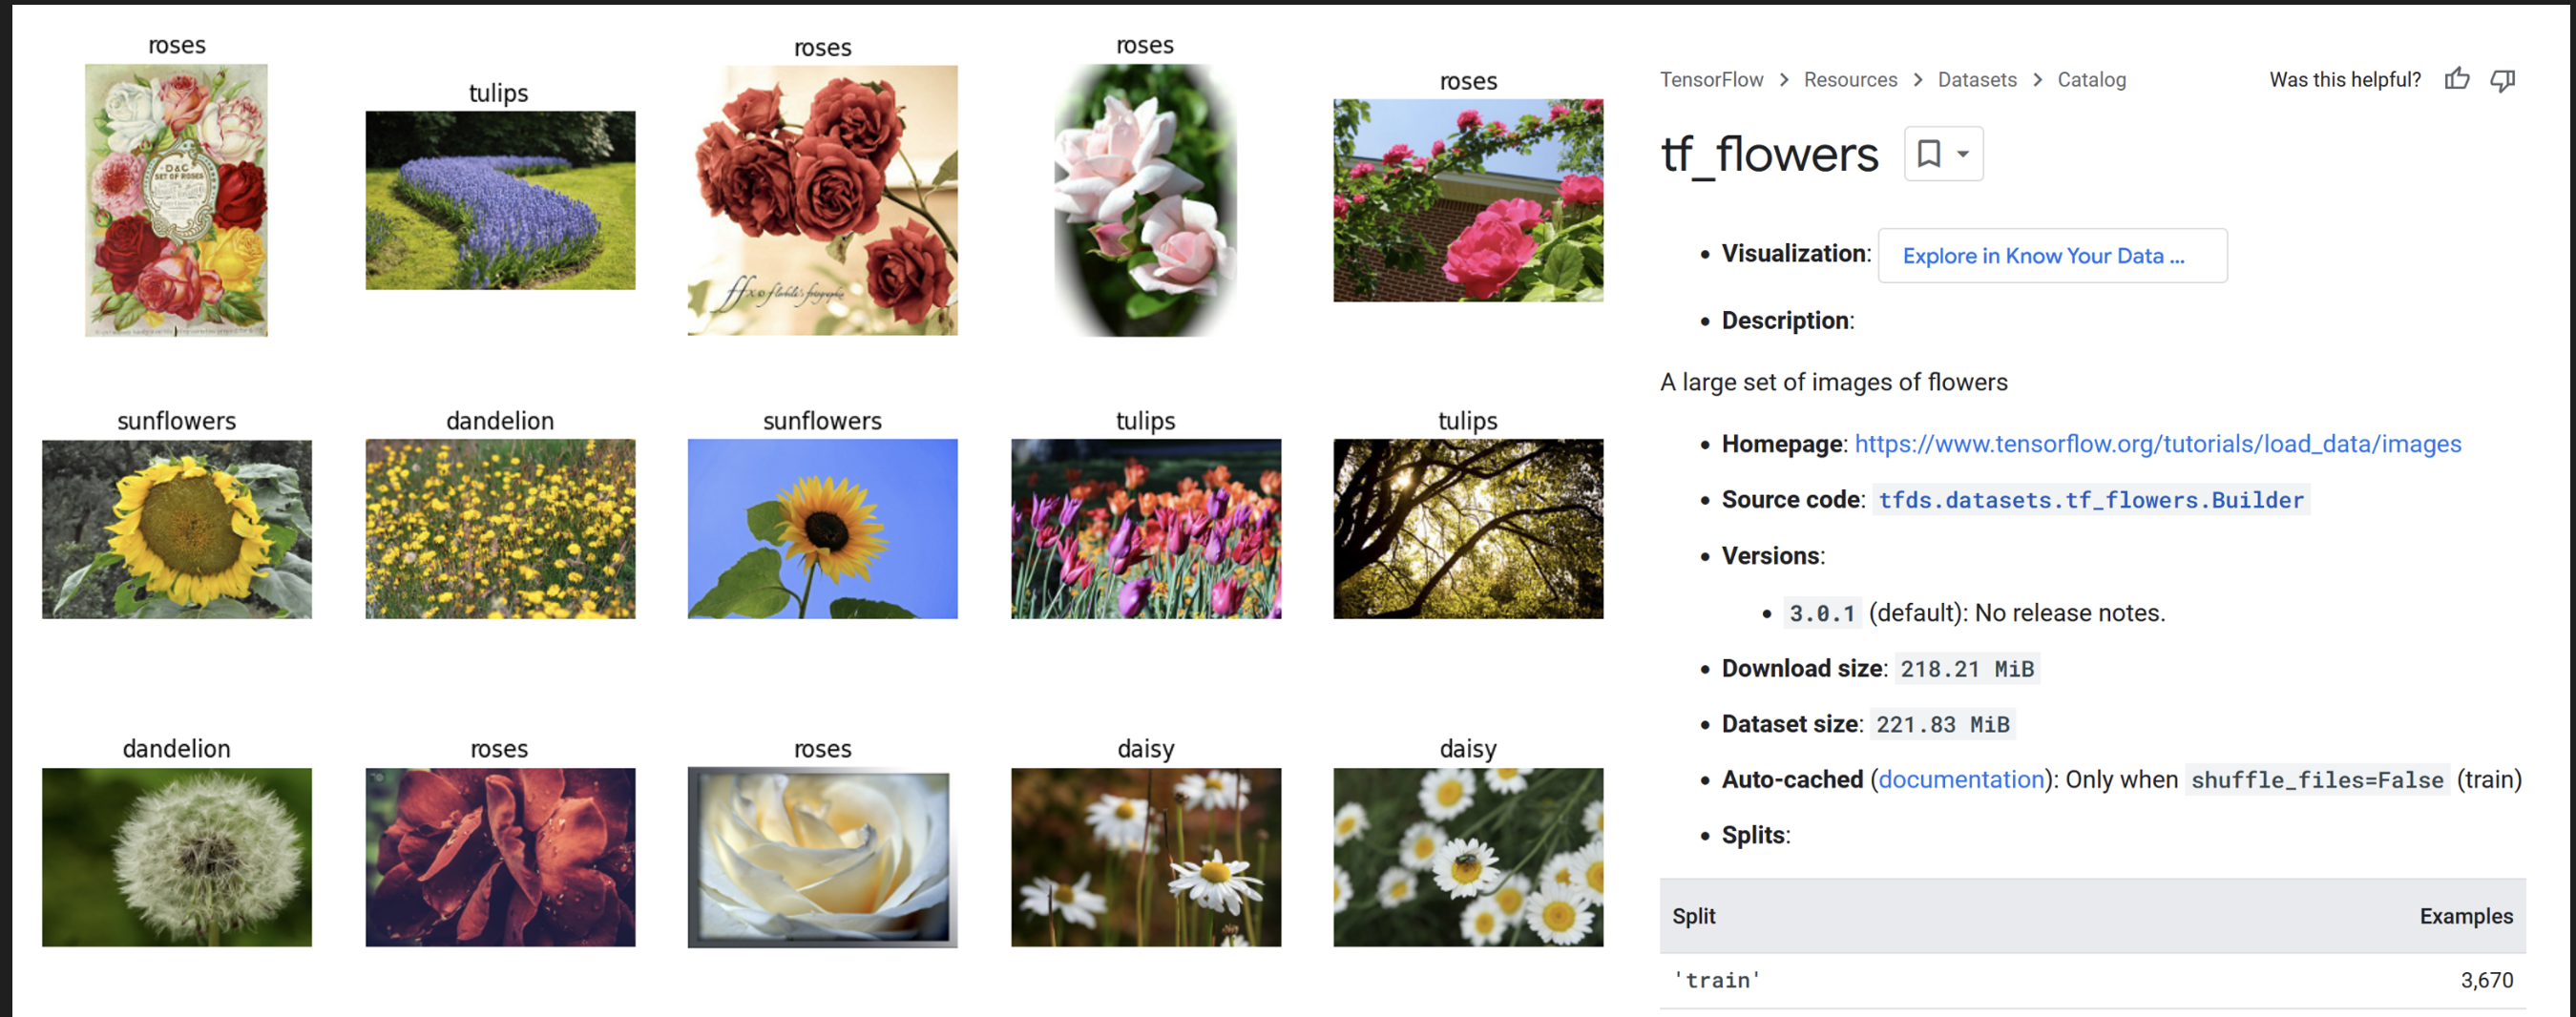


---

# Importing libraries 📚

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt


## Step 1: Load the TensorFlow Flower Dataset 📥
>We load the `tf_flowers` dataset using TensorFlow Datasets.

>The dataset is split into **training**, **validation**, and **test sets** to ensure proper model evaluation.

In [ ]:
(train_data, val_data, test_data), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

class_names = metadata.features['label'].names
print(f"Class names: {class_names}")

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [ ]:
# Print the number of images in each dataset split
train_count = sum(1 for _ in train_data)
val_count = sum(1 for _ in val_data)
test_count = sum(1 for _ in test_data)

print(f"Number of training images: {train_count}")
print(f"Number of validation images: {val_count}")
print(f"Number of test images: {test_count}")

Number of training images: 2936
Number of validation images: 367
Number of test images: 367


## Step 2: Visualize the Dataset 🖼️

>Visualize a few samples from the dataset to understand its structure and classes.
  

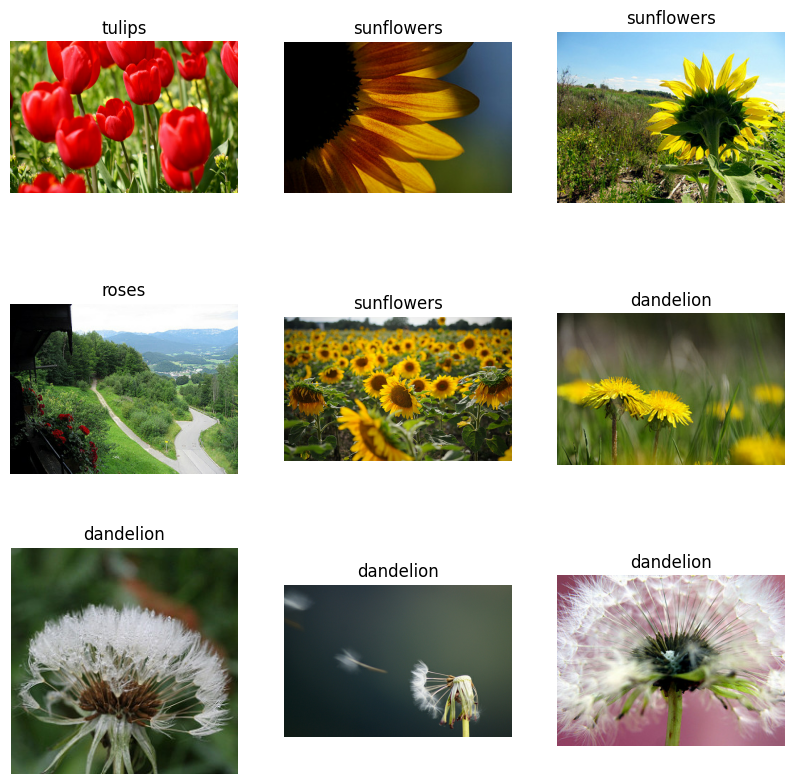

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_data.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_names[label.numpy()])
    plt.axis("off")
plt.show()


## Step 3: Preprocessing the Data ✂️
>Techniques Used:

>Resizing images to 150x150 pixels.

>Normalizing pixel values.

>Data augmentation techniques like flipping, rotation, zoom, and translation.


In [ ]:
# Defining preprocessing with resizing, rescaling, and augmentation
IMG_SIZE = 150
AUTOTUNE = tf.data.AUTOTUNE

resize_rescale_augment = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),  # Resize images
    tf.keras.layers.Rescaling(1./255),            # Rescale pixel values to [0, 1]
    tf.keras.layers.RandomFlip("horizontal"),    # Random horizontal flip
    tf.keras.layers.RandomRotation(0.1),         # Random rotation
    tf.keras.layers.RandomZoom(0.1),             # Random zoom
    tf.keras.layers.RandomTranslation(0.1, 0.1)  # Random translation
])

  > Define the funcation

In [ ]:
def prepare_images_with_augmentation(ds, shuffle=False):
    # Resize, rescale, and augment the dataset.
    ds = ds.map(lambda x, y: (resize_rescale_augment(x), y),
                num_parallel_calls=AUTOTUNE)

    # Shuffle the dataset if specified
    if shuffle:
        ds = ds.shuffle(1000)

    # Batch and prefetch the dataset
    ds = ds.batch(32).prefetch(buffer_size=AUTOTUNE)  # Adjust batch size as needed
    return ds

>Apply augmentation to training data and process validation and test data


In [ ]:
# Apply augmentation to training data and process validation and test data
train_data = prepare_images_with_augmentation(train_data, shuffle=True)
val_data = prepare_images_with_augmentation(val_data)
test_data = prepare_images_with_augmentation(test_data)

> Visualize the train dataset after augmentation


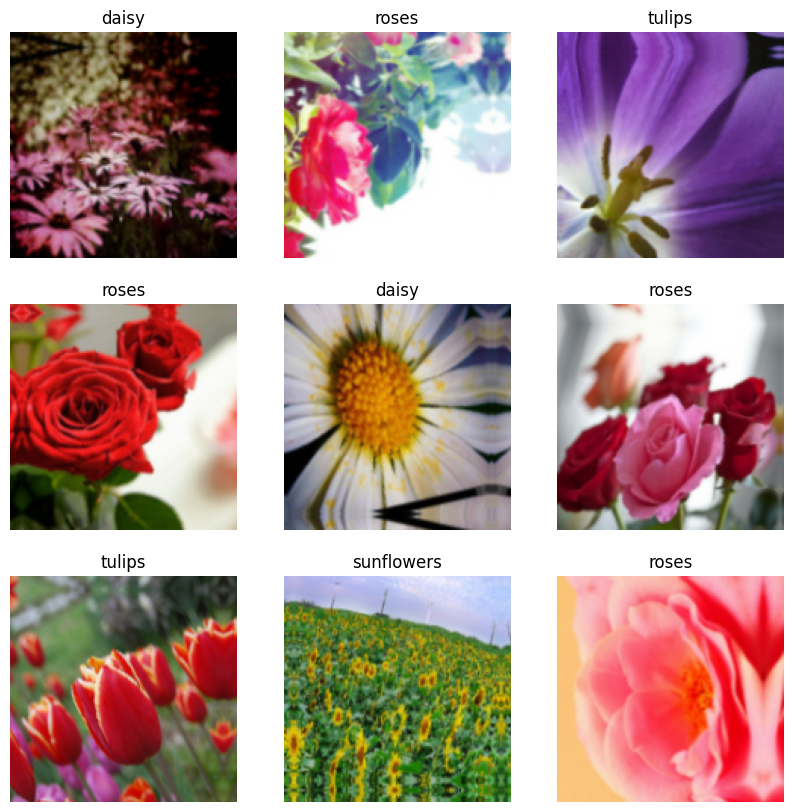

In [ ]:
# Visualize the train dataset after augmentation
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_data.take(9)):  # Directly take 9 augmented examples
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0].numpy())  # Access the first image from the batch
    plt.title(class_names[label[0].numpy()])  # Access the first label from the batch
    plt.axis("off")
plt.show()


---

# **Model Development and Training**
The development of the flower classification model involved implementing two approaches: a baseline Convolutional Neural Network (CNN) and a model using Transfer Learning with the VGG16 architecture [3]. Both models were designed to classify images into five categories, leveraging the preprocessed tf_flowers dataset.

The baseline CNN consisted of three convolutional layers, each followed by max-pooling layers to progressively reduce the spatial dimensions while extracting key features. The architecture concluded with a fully connected layer and a softmax output layer for multiclass classification. Dropout regularization was applied to mitigate overfitting. The model was compiled using the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the performance metric. Training was conducted for 10 epochs using the augmented training dataset, with validation performed after each epoch.

For the Transfer Learning approach, the VGG16 model, pre-trained on ImageNet, was used as a feature extractor. The base layers of VGG16 were frozen to retain their pre-trained weights, while additional dense and dropout layers were appended for classification. The model was fine-tuned with the same optimizer, loss function, and metric as the baseline CNN, and trained over 10 epochs. This approach leveraged the pre-trained features of VGG16 to enhance performance with minimal computational cost.

Both models were implemented in TensorFlow and trained on the preprocessed dataset. Training and validation accuracy, as well as loss metrics, were monitored to assess the models' performance during training.

___

##  Step 4:  Baseline CNN Model ⚒️

#Architecture:

>Input Layer: Image dimensions 150x150x3.

>Convolutional Layers: Feature extraction using Conv2D layers.

>Fully Connected Layers: Dense layers for classification

## Building the Model


In [ ]:

# Define the baseline CNN model
baseline_model = Sequential([
    # First convolutional block
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional block
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flattening and fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(len(class_names), activation='softmax')  # Output layer for multi-class classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse for integer labels
    metrics=['accuracy']
)

In [ ]:
# Print the model summary
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      37,880,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,253,701 (145.93 MB)

 Trainable params: 38,253,701 (145.93 MB)

 Non-trainable params: 0 (0.00 B)

# Training:

In [ ]:
# Train the model
baseline_history = baseline_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10  # Adjust epochs as needed
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 387ms/step - accuracy: 0.3137 - loss: 2.0112 - val_accuracy: 0.5586 - val_loss: 1.1410
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.5182 - loss: 1.1377 - val_accuracy: 0.6104 - val_loss: 1.0503
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.5927 - loss: 1.0287 - val_accuracy: 0.6567 - val_loss: 0.9015
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.6336 - loss: 0.9402 - val_accuracy: 0.6567 - val_loss: 0.8762
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - accuracy: 0.6657 - loss: 0.8905 - val_accuracy: 0.7057 - val_loss: 0.7827
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.6861 - loss: 0.8289 - val_accuracy: 0.6812 - val_loss: 0.8452
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 277ms/step - accuracy: 0.7041 - loss: 0.8059 - val_accuracy: 0.6757 - val_loss: 0.8042
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.6934 - loss: 0.7948 - val_accu

#  Visualize  and analysis Performance for Baseline CNN:

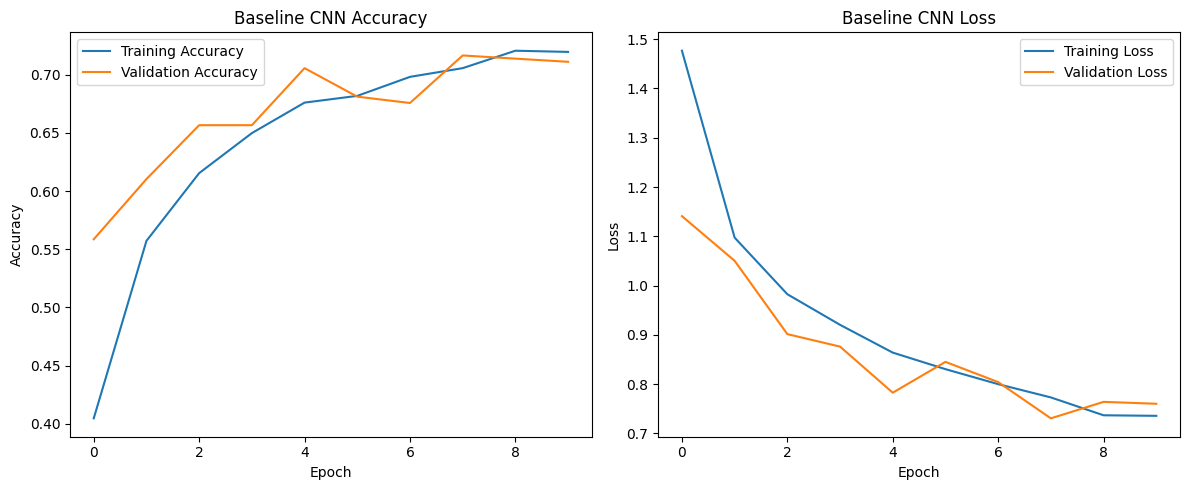

In [ ]:
# Visualize Training and Validation Performance for Baseline CNN
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(baseline_history.history['accuracy'], label='Training Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(baseline_history.history['loss'], label='Training Loss')
plt.plot(baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Baseline CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step


<Figure size 1000x800 with 0 Axes>

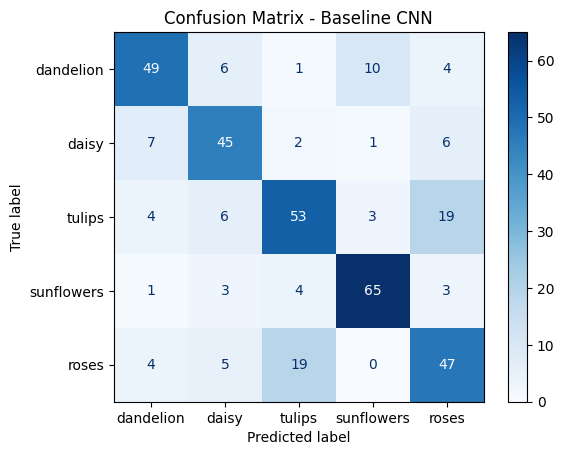

In [ ]:

# Predict on the test data
y_true = np.concatenate([y.numpy() for x, y in test_data], axis=0)  # True labels
y_pred = np.argmax(baseline_model.predict(test_data), axis=1)  # Predictions for Baseline CNN

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Baseline CNN")
plt.show()


In [ ]:

# Generate a classification report
print("Classification Report - Baseline CNN:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report - Baseline CNN:
              precision    recall  f1-score   support

   dandelion       0.75      0.70      0.73        70
       daisy       0.69      0.74      0.71        61
      tulips       0.67      0.62      0.65        85
  sunflowers       0.82      0.86      0.84        76
       roses       0.59      0.63      0.61        75

    accuracy                           0.71       367
   macro avg       0.71      0.71      0.71       367
weighted avg       0.71      0.71      0.71       367



# Evaluation:

In [ ]:
# Evaluate the model on the test dataset
baseline_test_loss, baseline_test_accuracy = baseline_model.evaluate(test_data)
print(f"Test Accuracy: {baseline_test_accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.6892 - loss: 0.7412
Test Accuracy: 72.75%


##  Step 5:  Transfer Learning with VGG16⚒️

#Model Adjustments:

>Base layers frozen.

>Additional dense and dropout layers added for classification.

## Building the Model



In [ ]:

# Load the VGG16 base model
vgg16_base = VGG16(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Freeze the base model layers to prevent them from being updated during training
for layer in vgg16_base.layers:
    layer.trainable = False

In [ ]:
# Create a new model on top of the VGG16 base
vgg16_model = Sequential([
    vgg16_base,  # Add the pre-trained VGG16 base
    Flatten(),  # Flatten the output of the base model
    Dense(512, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(len(class_names), activation='softmax')  # Output layer for multi-class classification
])

In [ ]:
# Compile the model
vgg16_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse for integer labels
    metrics=['accuracy']
)

In [ ]:
# Print the model summary
vgg16_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,912,069 (72.14 MB)

 Trainable params: 4,197,381 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Training:


In [ ]:
# Train the model
vgg16_history = vgg16_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10  # Adjust epochs as needed
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 381ms/step - accuracy: 0.4828 - loss: 1.7655 - val_accuracy: 0.7275 - val_loss: 0.7160
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 244ms/step - accuracy: 0.7106 - loss: 0.7663 - val_accuracy: 0.7548 - val_loss: 0.7071
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 263ms/step - accuracy: 0.7284 - loss: 0.7250 - val_accuracy: 0.7684 - val_loss: 0.6165
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - accuracy: 0.7493 - loss: 0.6879 - val_accuracy: 0.7575 - val_loss: 0.6330
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - accuracy: 0.7834 - loss: 0.6066 - val_accuracy: 0.7493 - val_loss: 0.6736
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.7733 - loss: 0.6032 - val_accuracy: 0.7439 - val_loss: 0.6434
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 262ms/step - accuracy: 0.7742 - loss: 0.6025 - val_accuracy: 0.7684 - val_loss: 0.6019
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 259ms/step - accuracy: 0.7939 - loss: 0.5441 - val_accu

#  Visualize  and analysis Performance for VGG16:

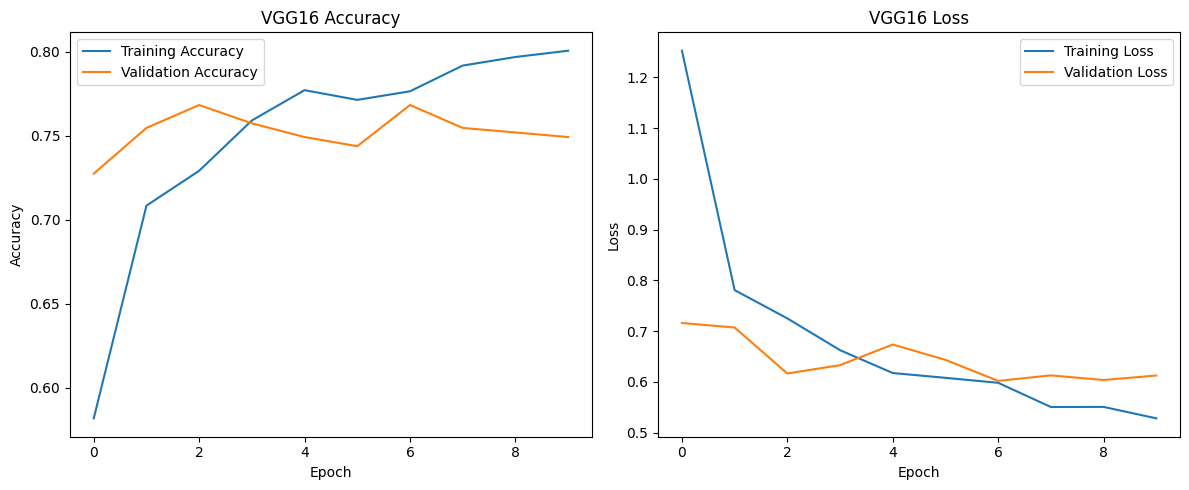

In [ ]:
# Visualize Training and Validation Performance for VGG16
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['loss'], label='Training Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step


<Figure size 1000x800 with 0 Axes>

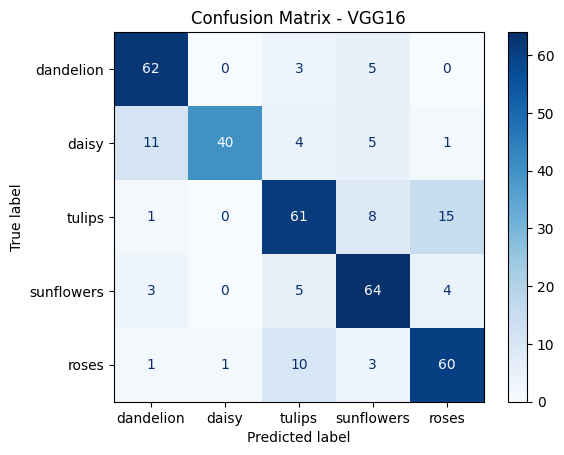

In [ ]:
y_pred_vgg16 = np.argmax(vgg16_model.predict(test_data), axis=1)  # Predictions for VGG16

# Compute and display confusion matrix
cm_vgg16 = confusion_matrix(y_true, y_pred_vgg16, labels=range(len(class_names)))
disp_vgg16 = ConfusionMatrixDisplay(confusion_matrix=cm_vgg16, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp_vgg16.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - VGG16")
plt.show()


In [ ]:

# Predict on the test data using VGG16 model
y_pred_vgg16 = np.argmax(vgg16_model.predict(test_data), axis=1)  # Predicted labels
y_true = np.concatenate([y.numpy() for x, y in test_data], axis=0)  # True labels

# Generate and display the classification report
print("Classification Report - VGG16:")
print(classification_report(y_true, y_pred_vgg16, target_names=class_names))


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step
Classification Report - VGG16:
              precision    recall  f1-score   support

   dandelion       0.78      0.89      0.83        70
       daisy       0.95      0.66      0.78        61
      tulips       0.79      0.74      0.76        85
  sunflowers       0.75      0.88      0.81        76
       roses       0.77      0.79      0.78        75

    accuracy                           0.79       367
   macro avg       0.81      0.79      0.79       367
weighted avg       0.80      0.79      0.79       367



# Evaluation:

In [ ]:
# Evaluate the model on the test dataset
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_data)
print(f"Test Accuracy with Transfer Learning (VGG16): {vgg16_test_accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.8040 - loss: 0.5297
Test Accuracy with Transfer Learning (VGG16): 80.38%


-------

# **Evaluation and Analysis**
The performance of the models was evaluated using accuracy, confusion matrices, and classification reports, providing a comprehensive assessment of their strengths and limitations.

**Evaluation Metrics**

Accuracy was employed as a primary metric to quantify the proportion of correctly classified instances. Confusion matrices were used to analyze the distribution of correct and incorrect predictions across the five flower classes, while classification reports detailed precision, recall, and F1-score for each category. These metrics allowed for a nuanced comparison of model performance, particularly in handling inter-class similarities.

**Baseline CNN vs. VGG16 Performance**

The baseline CNN achieved a test accuracy of 72.75%, demonstrating its ability to perform multiclass classification. However, it showed noticeable misclassifications between visually similar classes, as reflected in its confusion matrix. Precision and recall for certain categories, such as daisy and sunflower, were relatively low, indicating challenges in distinguishing between these classes.

In contrast, the Transfer Learning model utilizing VGG16 achieved a superior test accuracy of 80.38%, outperforming the baseline model in all evaluated metrics. The VGG16 model's confusion matrix revealed significantly fewer misclassifications, highlighting its robust feature extraction capabilities. The classification report underscored this performance, with consistently higher precision, recall, and F1-scores across all classes compared to the baseline CNN. These results demonstrate the effectiveness of Transfer Learning in leveraging pre-trained features to enhance classification performance, particularly when training data is limited.

**Performance Visualization**

The training and validation accuracy curves for both models revealed key insights into their learning behaviors. While the baseline CNN exhibited signs of overfitting after a few epochs, the VGG16 model maintained stable generalization throughout training. Similarly, loss curves confirmed the superior convergence properties of the VGG16 model, reinforcing its reliability for this classification task.



----

## Step 6: Compare Models and Show Results

In [ ]:

# Extract validation accuracy for both models
baseline_val_accuracy = baseline_history.history['val_accuracy']
vgg16_val_accuracy = vgg16_history.history['val_accuracy']

In [ ]:
# Extract training accuracy for both models
baseline_train_accuracy = baseline_history.history['accuracy']
vgg16_train_accuracy = vgg16_history.history['accuracy']

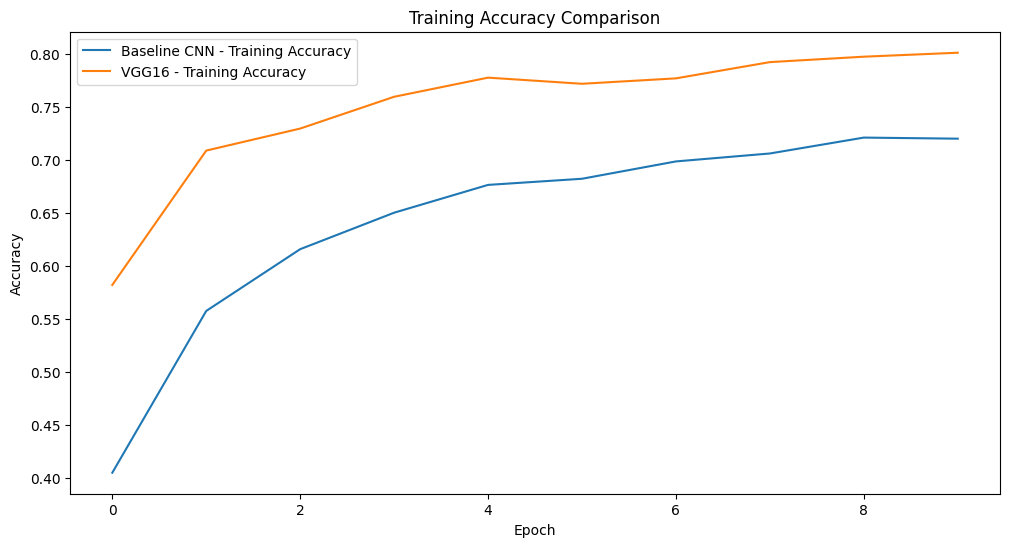

In [ ]:
# Plot Training Accuracy
plt.figure(figsize=(12, 6))
plt.plot(baseline_train_accuracy, label='Baseline CNN - Training Accuracy')
plt.plot(vgg16_train_accuracy, label='VGG16 - Training Accuracy')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

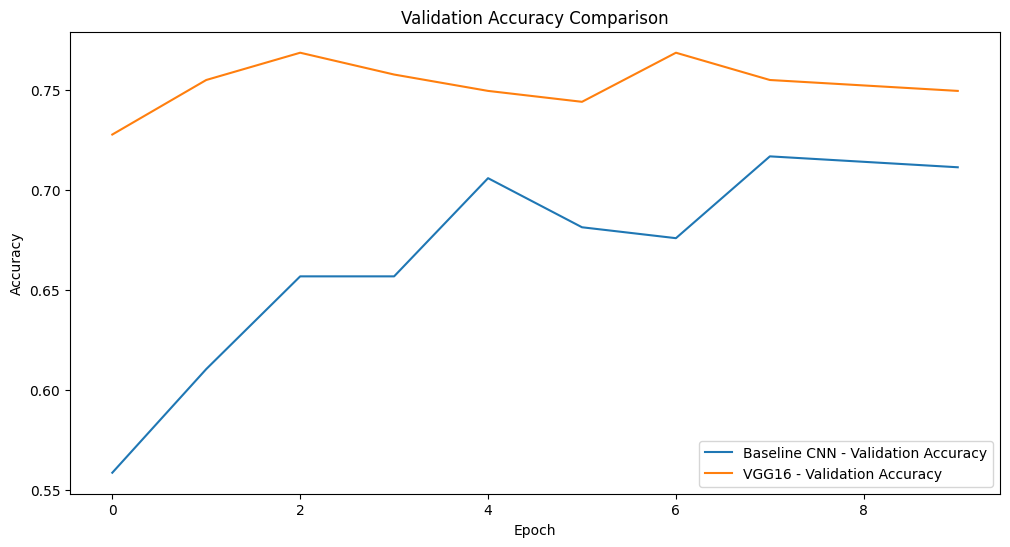

In [ ]:
# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(baseline_val_accuracy, label='Baseline CNN - Validation Accuracy')
plt.plot(vgg16_val_accuracy, label='VGG16 - Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(f"Baseline CNN - Test Accuracy: {baseline_test_accuracy * 100:.2f}%")
print(f"VGG16 Transfer Learning - Test Accuracy: {vgg16_test_accuracy * 100:.2f}%")

Baseline CNN - Test Accuracy: 72.75%
VGG16 Transfer Learning - Test Accuracy: 80.38%


---

# **Conclusion and Future Work**

The results of this study emphasize the effectiveness of Transfer Learning in improving flower classification performance. While the baseline CNN demonstrated the capacity to learn and distinguish between different flower classes, it struggled in cases where inter-class similarities were subtle. In contrast, the VGG16-based Transfer Learning model achieved higher accuracy and more balanced precision, recall, and F1-scores across all classes. This improvement can be attributed to the rich, pre-trained feature representations learned from a large and diverse dataset, which allowed for more robust feature extraction and better generalization.

Looking ahead, there are several potential avenues for enhancing this work. Fine-tuning additional layers of the pre-trained model may yield even better performance by allowing more specialized feature adjustment for this specific classification task. Exploring more advanced augmentation techniques or leveraging larger, more diverse datasets could further bolster the model’s ability to generalize. Additionally, incorporating state-of-the-art architectures, such as EfficientNet or Vision Transformers, may provide further gains in accuracy and efficiency. Ultimately, these future directions can help create even more reliable and effective deep learning solutions for flower classification and related applications.


---

#**Reference**

[1] GeeksforGeeks, “Convolutional Neural Network (CNN) in machine learning,” GeeksforGeeks, Mar. 13, 2024. https://www.geeksforgeeks.org/convolutional-neural-network-cnn-in-machine-learning/

[2] “tf_flowers,” TensorFlow. https://www.tensorflow.org/datasets/catalog/tf_flowers



[3] Pk, “How to do transfer learning from the Keras VGG16 model?,” Medium, Feb. 06, 2024. [Online]. Available: https://medium.com/@ledubmurukp/how-to-do-transfer-learning-from-the-keras-vgg16-model-17470c1cdded


[4] V. Kohir, “Starting with TensorFlow Datasets -part 3; An end to end example for building a Flower Classifier,” Medium, Jan. 22, 2022. [Online]. Available: https://kvirajdatt.medium.com/starting-with-tensorflow-datasets-part-3-an-end-to-end-example-for-building-a-flowerclassifier-1b7c371447e1

